In [0]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt

# Fixed length bit string

## Use total sum as a target

In [0]:

class build_lstm_model_total_sum(nn.Module):
    
    def __init__(self):
        super(build_lstm_model_total_sum, self).__init__()
        self.unit_size = 1
        self.lstm1 = nn.LSTM(1,self.unit_size)
        self.fc1 = nn.Linear(self.unit_size,1)
        self.hidden = self.init_hidden()
        self.init_weights()
      
    def init_weights(self):
        initrange = 0.1
        self.lstm1.weight_ih_l0.data.uniform_(-initrange, initrange)
        self.lstm1.weight_hh_l0.data.uniform_(-initrange, initrange)
        self.lstm1.bias_ih_l0.data.zero_()
        self.lstm1.bias_hh_l0.data.zero_()
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)
        
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 500, self.unit_size).cuda(),
                torch.zeros(1, 500, self.unit_size).cuda())
        
    def forward(self, input):
        x, self.hidden = self.lstm1(input)
#         print('LSTM output shape',x.shape)
#         print('hidden state shape',self.hidden[1].shape)
#         x = x
#         print('Flatten shape',x.shape)
#         x = F.relu(x)
        x = self.fc1(x[-1])
        x = torch.sigmoid(x)
        

        return x

In [0]:
val = np.random.randint(2,size=(50,10000,1))
y_val = torch.from_numpy(val.cumsum(axis=0)%2).float().cuda()
val = torch.from_numpy(val).float().cuda()

RUN: 1 ........	Accuracy: 0.5
RUN: 2 ........	Accuracy: 0.5
RUN: 3 ........	Accuracy: 0.5
RUN: 4 ........	Accuracy: 0.5
RUN: 5 ........	Accuracy: 0.5
RUN: 6 ........	Accuracy: 0.5
RUN: 7 ........	Accuracy: 0.5
RUN: 8 ........	Accuracy: 0.5
RUN: 9 ........	Accuracy: 0.5
RUN: 10 ........	Accuracy: 0.5
RUN: 11 ........	Accuracy: 0.5
RUN: 12 ........	Accuracy: 0.5
RUN: 13 ........	Accuracy: 0.5
RUN: 14 ........	Accuracy: 0.5
RUN: 15 ........	Accuracy: 0.5
RUN: 16 ........	Accuracy: 0.5
RUN: 17 ........	Accuracy: 0.5
RUN: 18 ........	Accuracy: 0.5
RUN: 19 ........	Accuracy: 0.5
RUN: 20 ........	Accuracy: 0.5
RUN: 21 ........	Accuracy: 0.5
RUN: 22 ........	Accuracy: 0.5
RUN: 23 ........	Accuracy: 0.5
RUN: 24 ........	Accuracy: 0.5
RUN: 25 ........	Accuracy: 0.5
RUN: 26 ........	Accuracy: 0.5
RUN: 27 ........	Accuracy: 0.5
RUN: 28 ........	Accuracy: 0.5
RUN: 29 ........	Accuracy: 0.5
RUN: 30 ........	Accuracy: 0.5
RUN: 31 ........	Accuracy: 0.5
RUN: 32 ........	Accuracy: 0.5
RUN: 33 ........	

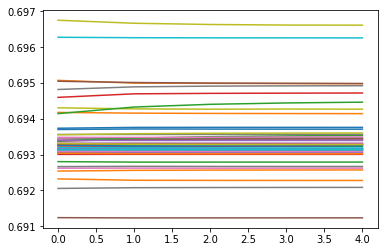

In [4]:
batch_size = 1000
ep_num = 5
runs = 50
loss_log = np.zeros((runs,ep_num))
converge_count = 0

for run in range(runs):
  print('RUN:',run+1,'...',end='')
  #create a model, loss function and optimizer
  lstm_model = build_lstm_model_total_sum().cuda().train()
  criterion = nn.BCELoss()
  optimizer = optim.Adam(lstm_model.parameters(), lr=0.05)
  
  #create training data
  data = np.random.randint(2,size=(50,100000,1))
  parity = torch.from_numpy(data.sum(axis=0)%2).float().cuda()
  data = torch.from_numpy(data).float().cuda()
  
  #train
  for epoch in range(ep_num):
    print('.',end='')
    for i in range(0,100000,batch_size):
      input_data = data[:,i:i+batch_size,:]
      target = parity[i:i+batch_size]

      output = lstm_model(input_data)
      loss = criterion(output,target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_log[run,epoch] = loss.item()
  if loss.item()<0.1:
    converge_count += 1
    
  pred = np.round(lstm_model(val).detach().cpu().numpy())
  acc = np.sum(pred==y_val.detach().cpu().numpy())/500000
  print('\tAccuracy:',round(acc,2))
print('Converged runs:',converge_count,'/',runs)
# the model don't converge using total sum as a target
for run in range(runs):
  plt.plot(loss_log[run,:])
plt.show()

## Use cumulative sum as a target (auxiliary task)

In [0]:

class build_lstm_model_cumsum(nn.Module):
    
    def __init__(self):
        super(build_lstm_model_cumsum, self).__init__()
        self.unit_size = 1
        self.lstm1 = nn.LSTM(1,self.unit_size)
        self.fc1 = nn.Linear(self.unit_size,1)
        self.hidden = self.init_hidden()
        self.init_weights()
      
    def init_weights(self):
        initrange = 0.1
        self.lstm1.weight_ih_l0.data.uniform_(-initrange, initrange)
        self.lstm1.weight_hh_l0.data.uniform_(-initrange, initrange)
        self.lstm1.bias_ih_l0.data.zero_()
        self.lstm1.bias_hh_l0.data.zero_()
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)
        
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 500, self.unit_size).cuda(),
                torch.zeros(1, 500, self.unit_size).cuda())
        
    def forward(self, input):
        x, self.hidden = self.lstm1(input)
#         print('LSTM output shape',x.shape)
#         print('hidden state shape',self.hidden[1].shape)
#         x = x
#         print('Flatten shape',x.shape)
#         x = F.relu(x)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        

        return x

RUN: 1 ........	Accuracy: 1.0
RUN: 2 ........	Accuracy: 1.0
RUN: 3 ........	Accuracy: 1.0
RUN: 4 ........	Accuracy: 1.0
RUN: 5 ........	Accuracy: 1.0
RUN: 6 ........	Accuracy: 1.0
RUN: 7 ........	Accuracy: 1.0
RUN: 8 ........	Accuracy: 1.0
RUN: 9 ........	Accuracy: 1.0
RUN: 10 ........	Accuracy: 1.0
RUN: 11 ........	Accuracy: 1.0
RUN: 12 ........	Accuracy: 1.0
RUN: 13 ........	Accuracy: 1.0
RUN: 14 ........	Accuracy: 1.0
RUN: 15 ........	Accuracy: 1.0
RUN: 16 ........	Accuracy: 1.0
RUN: 17 ........	Accuracy: 1.0
RUN: 18 ........	Accuracy: 1.0
RUN: 19 ........	Accuracy: 1.0
RUN: 20 ........	Accuracy: 1.0
RUN: 21 ........	Accuracy: 1.0
RUN: 22 ........	Accuracy: 0.51
RUN: 23 ........	Accuracy: 1.0
RUN: 24 ........	Accuracy: 1.0
RUN: 25 ........	Accuracy: 1.0
RUN: 26 ........	Accuracy: 1.0
RUN: 27 ........	Accuracy: 1.0
RUN: 28 ........	Accuracy: 1.0
RUN: 29 ........	Accuracy: 1.0
RUN: 30 ........	Accuracy: 1.0
RUN: 31 ........	Accuracy: 1.0
RUN: 32 ........	Accuracy: 1.0
RUN: 33 ........

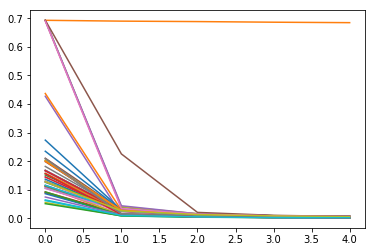

In [6]:
batch_size = 1000
ep_num = 5
runs = 50
loss_log = np.zeros((runs,ep_num))
converge_count = 0

for run in range(runs):
  print('RUN:',run+1,'...',end='')
  #create a model, loss functoin and optimizer
  lstm_model = build_lstm_model_cumsum().cuda().train()
  criterion = nn.BCELoss()
  optimizer = optim.Adam(lstm_model.parameters(), lr=0.05)
  
  #create training data
  data = np.random.randint(2,size=(50,100000,1))
  parity = torch.from_numpy(data.cumsum(axis=0)%2).float().cuda()
  data = torch.from_numpy(data).float().cuda()
  
  #train
  for epoch in range(ep_num):
    print('.',end='')
    for i in range(0,100000,batch_size):
      input_data = data[:,i:i+batch_size,:]
      target = parity[:,i:i+batch_size,:]
      #net.zero_grad()
      #net.hidden = net.init_hidden()

      output = lstm_model(input_data)
      loss = criterion(output,target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_log[run,epoch] = loss.item()
    
  if loss.item()<0.1:
    converge_count += 1
    
  pred = np.round(lstm_model(val).detach().cpu().numpy())
  acc = np.sum(pred==y_val.detach().cpu().numpy())/500000
  print('\tAccuracy:',round(acc,2))
print('Converged runs:',converge_count,'/',runs)
  
# the model converge most of the time but sometimes don't
for run in range(runs):
  plt.plot(loss_log[run,:])
plt.show()

## Variable bit string

RUN: 1 ........	Accuracy: 1.0
RUN: 2 ........	Accuracy: 1.0
RUN: 3 ........	Accuracy: 1.0
RUN: 4 ........	Accuracy: 1.0
RUN: 5 ........	Accuracy: 0.51
RUN: 6 ........	Accuracy: 1.0
RUN: 7 ........	Accuracy: 1.0
RUN: 8 ........	Accuracy: 1.0
RUN: 9 ........	Accuracy: 1.0
RUN: 10 ........	Accuracy: 1.0
RUN: 11 ........	Accuracy: 1.0
RUN: 12 ........	Accuracy: 1.0
RUN: 13 ........	Accuracy: 1.0
RUN: 14 ........	Accuracy: 1.0
RUN: 15 ........	Accuracy: 0.51
RUN: 16 ........	Accuracy: 1.0
RUN: 17 ........	Accuracy: 1.0
RUN: 18 ........	Accuracy: 1.0
RUN: 19 ........	Accuracy: 1.0
RUN: 20 ........	Accuracy: 1.0
RUN: 21 ........	Accuracy: 1.0
RUN: 22 ........	Accuracy: 1.0
RUN: 23 ........	Accuracy: 1.0
RUN: 24 ........	Accuracy: 1.0
RUN: 25 ........	Accuracy: 1.0
RUN: 26 ........	Accuracy: 1.0
RUN: 27 ........	Accuracy: 1.0
RUN: 28 ........	Accuracy: 1.0
RUN: 29 ........	Accuracy: 0.5
RUN: 30 ........	Accuracy: 1.0
RUN: 31 ........	Accuracy: 1.0
RUN: 32 ........	Accuracy: 1.0
RUN: 33 .......

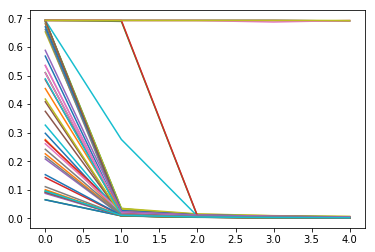

In [7]:
batch_size = 1000
ep_num = 5
runs = 50
loss_log = np.zeros((runs,ep_num))
converge_count = 0

for run in range(runs):
  print('RUN:',run+1,'...',end='')
  #create a model, loss functoin and optimizer
  lstm_model = build_lstm_model_cumsum().cuda().train()
  criterion = nn.BCELoss()
  optimizer = optim.Adam(lstm_model.parameters(), lr=0.05)
  
  #create training data
  var_inputs = np.zeros((50,100000,1))
  for i in range(100000):
    length = np.random.randint(1,51)
    temp = np.random.randint(2,size=(length,1))
    var_inputs[:length,i,:] = temp

  parity = torch.from_numpy(var_inputs.cumsum(axis=0)%2).float().cuda()
  data = torch.from_numpy(var_inputs).float().cuda()
  
  #train
  for epoch in range(ep_num):
    print('.',end='')
    for i in range(0,100000,batch_size):
      input_data = data[:,i:i+batch_size,:]
      target = parity[:,i:i+batch_size,:]
      #net.zero_grad()
      #net.hidden = net.init_hidden()

      output = lstm_model(input_data)
      loss = criterion(output,target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_log[run,epoch] = loss.item()
  if loss.item()<0.1:
    converge_count += 1
    
  pred = np.round(lstm_model(val).detach().cpu().numpy())
  acc = np.sum(pred==y_val.detach().cpu().numpy())/500000
  print('\tAccuracy:',round(acc,2))
print('Converged runs:',converge_count,'/',runs)
  
# the model converge most of the time but sometimes don't
for run in range(runs):
  plt.plot(loss_log[run,:])
plt.show()

In [0]:
#Maybe masking input sequences will help to get higher converged models